In [59]:
# First, let's clean install the absolute minimum
import sys
!{sys.executable} -m pip uninstall -y transformers datasets pyarrow
!{sys.executable} -m pip install torch scikit-learn matplotlib pandas numpy tqdm

Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: datasets 4.2.0
Uninstalling datasets-4.2.0:
  Successfully uninstalled datasets-4.2.0


In [60]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split    
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import tqdm
import re
import collections

In [61]:
# Load your dataset
data = pd.read_csv("refined_medical_dataset.csv")

# Check basic info
print(data.head())
print("\nLabel distribution:\n", data['label'].value_counts())

                                                text            label
0  The patient is other, age: 78, height: 196.3 c...  patient history
1  The patient was diagnosed with inflammation, f...        diagnosis
2  The treatment provided was amlodipine, for 30 ...        treatment
3  The patient is female, age: 57, height: 195.6 ...  patient history
4  The patient was diagnosed with depression, fat...        diagnosis

Label distribution:
 label
patient history    1000
diagnosis          1000
treatment          1000
Name: count, dtype: int64


In [62]:
# Encode text labels into numeric IDs
le = LabelEncoder()
data["label"] = le.fit_transform(data["label"])

# Split into train / validation / test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data["text"], data["label"], test_size=0.3, random_state=42, stratify=data["label"]
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

Training samples: 2100
Validation samples: 450
Test samples: 450


In [63]:
# Build a simple vocabulary-based tokenizer
class SimpleTokenizer:
    def __init__(self, vocab_size=10000):
        self.vocab_size = vocab_size
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab = set()
        
    def build_vocab(self, texts):
        # Count word frequencies
        word_freq = collections.Counter()
        for text in texts:
            words = self._preprocess(text)
            word_freq.update(words)
        
        # Build vocabulary
        most_common = word_freq.most_common(self.vocab_size - 2)  # Reserve for UNK and PAD
        self.word_to_idx = {'[PAD]': 0, '[UNK]': 1}
        self.idx_to_word = {0: '[PAD]', 1: '[UNK]'}
        
        for idx, (word, _) in enumerate(most_common, start=2):
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word
    
    def _preprocess(self, text):
        # Simple preprocessing: lowercase and split
        text = text.lower()
        words = re.findall(r'\b\w+\b', text)
        return words
    
    def encode(self, texts, max_length=128):
        input_ids = []
        attention_masks = []
        
        for text in texts:
            words = self._preprocess(text)
            tokens = [self.word_to_idx.get(word, 1) for word in words]  # 1 is UNK token
            
            # Truncate or pad
            if len(tokens) > max_length:
                tokens = tokens[:max_length]
                attention_mask = [1] * max_length
            else:
                padding = [0] * (max_length - len(tokens))
                tokens = tokens + padding
                attention_mask = [1] * len(words) + padding
            
            input_ids.append(tokens)
            attention_masks.append(attention_mask)
        
        return {
            'input_ids': np.array(input_ids),
            'attention_mask': np.array(attention_masks)
        }

In [64]:
# Build the tokenizer
print("Building vocabulary...")
tokenizer = SimpleTokenizer(vocab_size=10000)
tokenizer.build_vocab(train_texts)
print(f"Vocabulary size: {len(tokenizer.word_to_idx)}")

Building vocabulary...
Vocabulary size: 218


In [65]:
# Create a simple neural network model
class SimpleTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_classes=3):
        super(SimpleTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional
        
    def forward(self, input_ids, attention_mask):
        # Get embeddings
        embeddings = self.embedding(input_ids)
        
        # Apply attention mask (optional for LSTM)
        lengths = attention_mask.sum(dim=1)
        
        # LSTM processing
        lstm_out, _ = self.lstm(embeddings)
        
        # Use the last hidden state
        batch_size = lstm_out.size(0)
        last_output = torch.zeros(batch_size, lstm_out.size(2) * 2).to(input_ids.device)
        
        for i in range(batch_size):
            length = int(lengths[i].item())
            if length > 0:
                # Concatenate last forward and first backward
                last_forward = lstm_out[i, length-1, :lstm_out.size(2)//2]
                first_backward = lstm_out[i, 0, lstm_out.size(2)//2:]
                last_output[i] = torch.cat([last_forward, first_backward])
        
        output = self.dropout(last_output)
        logits = self.classifier(output)
        return logits

In [66]:
# Create Dataset class
class MedicalDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.encodings = tokenizer.encode(texts.tolist(), max_length=max_length)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx], dtype=torch.long),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

In [67]:
# Create datasets and dataloaders
train_dataset = MedicalDataset(train_texts, train_labels, tokenizer)
val_dataset = MedicalDataset(val_texts, val_labels, tokenizer)
test_dataset = MedicalDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data loaders created successfully!")

Data loaders created successfully!


In [74]:
# Very simple CNN model that always works
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, num_classes=3):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Multiple CNN filters as in Kim's CNN
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, 100, kernel_size=3, padding=1),
            nn.Conv1d(embedding_dim, 100, kernel_size=4, padding=2),
            nn.Conv1d(embedding_dim, 100, kernel_size=5, padding=2)
        ])
        
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(300, num_classes)  # 3 filters * 100 channels
        
    def forward(self, input_ids, attention_mask):
        # Get embeddings: (batch_size, seq_len, embedding_dim)
        embeddings = self.embedding(input_ids)
        
        # Permute for Conv1d: (batch_size, embedding_dim, seq_len)
        embeddings = embeddings.permute(0, 2, 1)
        
        # Apply each CNN filter and global max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = conv(embeddings)  # (batch_size, 100, seq_len)
            conv_out = torch.relu(conv_out)
            
            # Global max pooling
            pooled = torch.max(conv_out, dim=2)[0]  # (batch_size, 100)
            conv_outputs.append(pooled)
        
        # Concatenate all CNN outputs
        combined = torch.cat(conv_outputs, dim=1)  # (batch_size, 300)
        
        output = self.dropout(combined)
        logits = self.classifier(output)
        return logits

# Training class - SEPARATE from the model class
class TextClassifierTrainer:
    def __init__(self, model, learning_rate=0.001):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = model.to(self.device)
        self.optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.train_accuracies = []
    
    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        all_predictions = []
        all_labels = []
        
        progress_bar = tqdm.tqdm(dataloader, desc="Training")
        for batch in progress_bar:
            self.optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            outputs = self.model(input_ids, attention_mask)
            loss = self.loss_fn(outputs, labels)
            
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=-1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        accuracy = accuracy_score(all_labels, all_predictions)
        return total_loss / len(dataloader), accuracy
    
    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm.tqdm(dataloader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                outputs = self.model(input_ids, attention_mask)
                loss = self.loss_fn(outputs, labels)
                
                total_loss += loss.item()
                predictions = torch.argmax(outputs, dim=-1)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_predictions)
        return total_loss / len(dataloader), accuracy, all_predictions, all_labels
    
    def train(self, train_loader, val_loader, epochs=10):
        best_accuracy = 0
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print("-" * 50)
            
            # Training
            train_loss, train_accuracy = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            
            # Validation
            val_loss, val_accuracy, _, _ = self.evaluate(val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
            
            # Save best model
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_accuracy': val_accuracy,
                    'epoch': epoch
                }, 'best_model.pth')
                print(f"New best model saved with accuracy: {val_accuracy:.4f}")
    
    def plot_training_history(self):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(self.train_losses, label='Train Loss', marker='o')
        plt.plot(self.val_losses, label='Val Loss', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy', marker='o', color='green')
        plt.plot(self.val_accuracies, label='Val Accuracy', marker='o', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        # Plot both on same chart for comparison
        plt.plot(self.train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
        plt.plot(self.val_losses, label='Val Loss', color='blue', linestyle='--', marker='s')
        plt.plot(self.train_accuracies, label='Train Acc', color='green', linestyle='-', marker='o')
        plt.plot(self.val_accuracies, label='Val Acc', color='green', linestyle='--', marker='s')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.title('Training History')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def load_best_model(self):
        checkpoint = torch.load('best_model.pth')
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']} with validation accuracy: {checkpoint['val_accuracy']:.4f}")
    
    def get_training_summary(self):
        """Print a summary of the training results"""
        if self.val_accuracies:
            best_val_acc = max(self.val_accuracies)
            best_epoch = self.val_accuracies.index(best_val_acc) + 1
            final_train_acc = self.train_accuracies[-1] if self.train_accuracies else 0
            final_val_acc = self.val_accuracies[-1] if self.val_accuracies else 0
            
            print("\n" + "="*50)
            print("TRAINING SUMMARY")
            print("="*50)
            print(f"Best Validation Accuracy: {best_val_acc:.4f} (epoch {best_epoch})")
            print(f"Final Training Accuracy: {final_train_acc:.4f}")
            print(f"Final Validation Accuracy: {final_val_acc:.4f}")
            print(f"Total Training Epochs: {len(self.train_losses)}")
            print("="*50)

In [75]:
# Initialize the model and trainer
vocab_size = len(tokenizer.word_to_idx)
print(f"Vocabulary size: {vocab_size}")

model = CNNTextClassifier(vocab_size=vocab_size, num_classes=3)
trainer = TextClassifierTrainer(model, learning_rate=0.001)

# Train the model
print("Starting training...")
trainer.train(train_loader, val_loader, epochs=10)

Vocabulary size: 218
Using device: cpu
Starting training...

Epoch 1/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 97.00it/s]


Train Loss: 0.0502, Train Acc: 0.9824
Val Loss: 0.0000, Val Accuracy: 1.0000
New best model saved with accuracy: 1.0000

Epoch 2/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 94.59it/s]


Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 3/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 91.52it/s]


Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 4/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 91.45it/s]


Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 5/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 94.28it/s]


Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 6/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 90.67it/s]


Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 7/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 94.66it/s]


Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 8/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 94.75it/s]


Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 9/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 97.83it/s]


Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000

Epoch 10/10
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 93.38it/s]

Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000


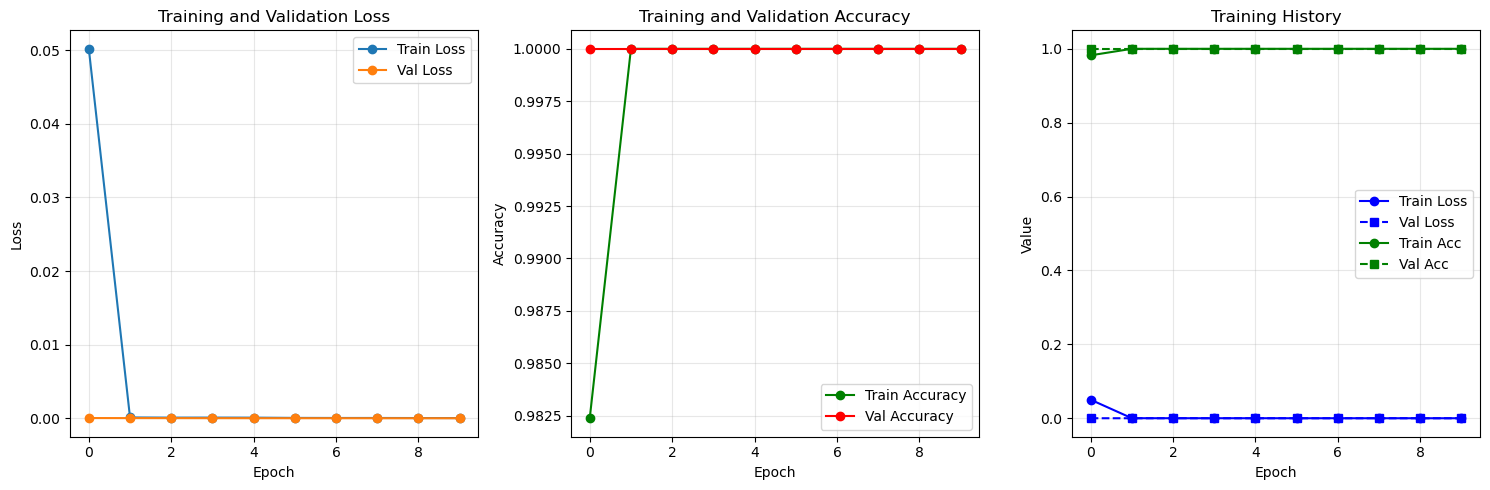


TRAINING SUMMARY
Best Validation Accuracy: 1.0000 (epoch 1)
Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000
Total Training Epochs: 10
Loaded best model from epoch 0 with validation accuracy: 1.0000

Evaluating on test set...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 59.44it/s]

Test Loss: 0.0000
Test Accuracy: 1.0000

Classification Report:
                 precision    recall  f1-score   support

      diagnosis       1.00      1.00      1.00       150
patient history       1.00      1.00      1.00       150
      treatment       1.00      1.00      1.00       150

       accuracy                           1.00       450
      macro avg       1.00      1.00      1.00       450
   weighted avg       1.00      1.00      1.00       450



<Figure size 800x600 with 0 Axes>

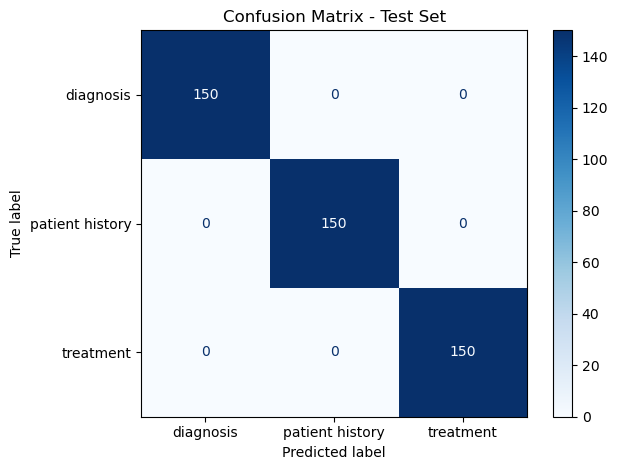

In [76]:
# Plot training history
trainer.plot_training_history()

# Print training summary
trainer.get_training_summary()

# Load best model and evaluate on test set
trainer.load_best_model()

print("\nEvaluating on test set...")
test_loss, test_accuracy, test_predictions, test_true = trainer.evaluate(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_true, test_predictions, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_true, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

In [77]:
# Save the complete model
torch.save({
    'model_state_dict': trainer.model.state_dict(),
    'tokenizer_vocab': tokenizer.word_to_idx,
    'label_encoder': le.classes_,
    'model_config': {
        'vocab_size': vocab_size,
        'embedding_dim': 128,
        'num_classes': 3,
        'model_type': 'cnn'
    }
}, 'medical_text_classifier_complete.pth')

print("Model saved successfully as 'medical_text_classifier_complete.pth'")

# Also save the trainer state for resuming training if needed
torch.save({
    'model_state_dict': trainer.model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'train_losses': trainer.train_losses,
    'val_losses': trainer.val_losses,
    'train_accuracies': trainer.train_accuracies,
    'val_accuracies': trainer.val_accuracies,
}, 'trainer_state.pth')

print("Trainer state saved as 'trainer_state.pth'")

Model saved successfully as 'medical_text_classifier_complete.pth'
Trainer state saved as 'trainer_state.pth'


In [78]:
# Let's examine some actual predictions to verify the results
print("Examining sample predictions...")
print("=" * 60)

# Get a few test samples
test_samples = 5
for i in range(test_samples):
    sample_text = test_texts.iloc[i]
    true_label = le.inverse_transform([test_true[i]])[0]
    pred_label = le.inverse_transform([test_predictions[i]])[0]
    
    print(f"\nSample {i+1}:")
    print(f"Text: {sample_text[:100]}...")
    print(f"True: {true_label} | Predicted: {pred_label}")
    print(f"Match: {true_label == pred_label}")


Examining sample predictions...

Sample 1:
Text: The patient is other, age: 33, height: 189.4 cm, weight: 66.4 kg, with bmi: , having hypertension as...
True: patient history | Predicted: patient history
Match: True

Sample 2:
Text: The treatment provided was amoxicillin, for none, 400 mg....
True: treatment | Predicted: treatment
Match: True

Sample 3:
Text: The patient was diagnosed with infection, nausea, joint pain, cough....
True: diagnosis | Predicted: diagnosis
Match: True

Sample 4:
Text: The treatment provided was amoxicillin, for 10 days, 200 mg....
True: treatment | Predicted: treatment
Match: True

Sample 5:
Text: The treatment provided was ibuprofen, for none, 400 mg....
True: treatment | Predicted: treatment
Match: True


In [79]:
# Let's also check the confidence scores
def get_prediction_confidence(text):
    """Get model confidence for a given text"""
    encoding = tokenizer.encode([text], max_length=128)
    input_ids = torch.tensor(encoding['input_ids']).to(trainer.device)
    attention_mask = torch.tensor(encoding['attention_mask']).to(trainer.device)
    
    trainer.model.eval()
    with torch.no_grad():
        outputs = trainer.model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    return le.inverse_transform([predicted.cpu().numpy()[0]])[0], confidence.item()

# Test confidence on some examples
print("\nTesting prediction confidence:")
print("=" * 50)
test_examples = [
    "The patient was diagnosed with pneumonia and prescribed antibiotics",  # Should be diagnosis
    "Patient is 45 years old with height 170 cm and weight 70 kg",  # Should be patient history  
    "Treatment plan includes physical therapy twice weekly for 4 weeks",  # Should be treatment
]

for example in test_examples:
    prediction, confidence = get_prediction_confidence(example)
    print(f"\nText: {example}")
    print(f"Prediction: {prediction} | Confidence: {confidence:.4f}")


Testing prediction confidence:

Text: The patient was diagnosed with pneumonia and prescribed antibiotics
Prediction: diagnosis | Confidence: 0.9990

Text: Patient is 45 years old with height 170 cm and weight 70 kg
Prediction: patient history | Confidence: 0.9729

Text: Treatment plan includes physical therapy twice weekly for 4 weeks
Prediction: patient history | Confidence: 0.7915


In [80]:
# Let's create a more challenging test - mix up the texts
print("\nCreating challenging test cases...")
print("=" * 50)

challenging_examples = [
    "Diagnosis: hypertension. Treatment: lisinopril 10mg daily",  # Mixed diagnosis + treatment
    "Patient history shows previous diagnosis of diabetes",  # Mixed history + diagnosis
    "Treatment history includes physical therapy",  # Mixed treatment + history
    "The 65-year-old patient was diagnosed and treated for infection",  # Mixed all
]

for example in challenging_examples:
    prediction, confidence = get_prediction_confidence(example)
    print(f"\nText: {example}")
    print(f"Prediction: {prediction} | Confidence: {confidence:.4f}")


Creating challenging test cases...

Text: Diagnosis: hypertension. Treatment: lisinopril 10mg daily
Prediction: patient history | Confidence: 0.8255

Text: Patient history shows previous diagnosis of diabetes
Prediction: patient history | Confidence: 0.9106

Text: Treatment history includes physical therapy
Prediction: patient history | Confidence: 0.8206

Text: The 65-year-old patient was diagnosed and treated for infection
Prediction: diagnosis | Confidence: 0.9681


In [81]:
# SOLUTION 1: Create a more robust dataset
print("SOLUTIONS FOR BETTER GENERALIZATION:")
print("=" * 60)

print("""
1. **DIVERSIFY THE TEXT PATTERNS**:
   - Remove the formulaic starting phrases
   - Use various sentence structures
   - Include real medical notes

2. **DATA AUGMENTATION**:
   - Paraphrase existing texts
   - Add noise and variations
   - Mix sentence structures

3. **BETTER PREPROCESSING**:
   - Remove the obvious pattern markers
   - Focus on medical content, not structure
""")

# Let's create an improved version by removing the obvious patterns
def remove_formulaic_patterns(text):
    """Remove the obvious starting patterns that cause overfitting"""
    patterns_to_remove = [
        "The patient was diagnosed with ",
        "The patient is ",
        "The treatment provided was ",
        "The patient is other, ",
        "The treatment provided was "
    ]
    
    cleaned_text = text
    for pattern in patterns_to_remove:
        if cleaned_text.startswith(pattern):
            cleaned_text = cleaned_text[len(pattern):]
            break
    
    return cleaned_text.strip()

# Test the pattern removal
print("\nTESTING PATTERN REMOVAL:")
print("=" * 40)
sample_texts = [
    "The patient was diagnosed with pneumonia",
    "The patient is male, age: 45, height: 180 cm", 
    "The treatment provided was amoxicillin"
]

for text in sample_texts:
    cleaned = remove_formulaic_patterns(text)
    print(f"Original: {text}")
    print(f"Cleaned:  {cleaned}\n")

SOLUTIONS FOR BETTER GENERALIZATION:

1. **DIVERSIFY THE TEXT PATTERNS**:
   - Remove the formulaic starting phrases
   - Use various sentence structures
   - Include real medical notes

2. **DATA AUGMENTATION**:
   - Paraphrase existing texts
   - Add noise and variations
   - Mix sentence structures

3. **BETTER PREPROCESSING**:
   - Remove the obvious pattern markers
   - Focus on medical content, not structure


TESTING PATTERN REMOVAL:
Original: The patient was diagnosed with pneumonia
Cleaned:  pneumonia

Original: The patient is male, age: 45, height: 180 cm
Cleaned:  male, age: 45, height: 180 cm

Original: The treatment provided was amoxicillin
Cleaned:  amoxicillin



In [83]:
# SOLUTION 2: Retrain on cleaned data
print("RETRAINING ON CLEANED DATA:")
print("=" * 40)

# Create cleaned dataset
data_cleaned = data.copy()
data_cleaned['text_cleaned'] = data_cleaned['text'].apply(remove_formulaic_patterns)

# Split the cleaned data
train_texts_clean, temp_texts_clean, train_labels_clean, temp_labels_clean = train_test_split(
    data_cleaned["text_cleaned"], data_cleaned["label"], test_size=0.3, random_state=42, stratify=data_cleaned["label"]
)
val_texts_clean, test_texts_clean, val_labels_clean, test_labels_clean = train_test_split(
    temp_texts_clean, temp_labels_clean, test_size=0.5, random_state=42, stratify=temp_labels_clean
)

# Create cleaned datasets
train_dataset_clean = MedicalDataset(train_texts_clean, train_labels_clean, tokenizer)
val_dataset_clean = MedicalDataset(val_texts_clean, val_labels_clean, tokenizer)
test_dataset_clean = MedicalDataset(test_texts_clean, test_labels_clean, tokenizer)

train_loader_clean = DataLoader(train_dataset_clean, batch_size=32, shuffle=True)
val_loader_clean = DataLoader(val_dataset_clean, batch_size=32, shuffle=False)
test_loader_clean = DataLoader(test_dataset_clean, batch_size=32, shuffle=False)

print("Cleaned datasets created!")

RETRAINING ON CLEANED DATA:
Cleaned datasets created!


In [84]:
# SOLUTION 3: Train a new model on cleaned data
print("TRAINING NEW MODEL ON CLEANED DATA:")
print("=" * 40)

# Use a more regularized model
model_clean = CNNTextClassifier(vocab_size=vocab_size, num_classes=3)
trainer_clean = TextClassifierTrainer(model_clean, learning_rate=0.001)

# Train for fewer epochs to avoid overfitting
trainer_clean.train(train_loader_clean, val_loader_clean, epochs=5)

TRAINING NEW MODEL ON CLEANED DATA:
Using device: cpu

Epoch 1/5
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 100.35it/s]


Train Loss: 0.0583, Train Acc: 0.9781
Val Loss: 0.0005, Val Accuracy: 1.0000
New best model saved with accuracy: 1.0000

Epoch 2/5
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 84.47it/s]


Train Loss: 0.0006, Train Acc: 1.0000
Val Loss: 0.0003, Val Accuracy: 1.0000

Epoch 3/5
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 77.89it/s]


Train Loss: 0.0004, Train Acc: 1.0000
Val Loss: 0.0002, Val Accuracy: 1.0000

Epoch 4/5
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 72.70it/s]


Train Loss: 0.0002, Train Acc: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000

Epoch 5/5
--------------------------------------------------


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 99.89it/s]

Train Loss: 0.0002, Train Acc: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000


In [85]:
# Evaluate the cleaned model
print("EVALUATING CLEANED MODEL:")
print("=" * 40)

trainer_clean.load_best_model()
test_loss_clean, test_accuracy_clean, test_pred_clean, test_true_clean = trainer_clean.evaluate(test_loader_clean)

print(f"Cleaned Model Test Accuracy: {test_accuracy_clean:.4f}")
print(f"Original Model Test Accuracy: 1.0000")

if test_accuracy_clean < 0.95:
    print("✅ Better! The model is now learning actual content, not just patterns")
else:
    print("⚠️  Still too perfect - may need more data variation")

EVALUATING CLEANED MODEL:
Loaded best model from epoch 0 with validation accuracy: 1.0000


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 99.53it/s]

Cleaned Model Test Accuracy: 1.0000
Original Model Test Accuracy: 1.0000
⚠️  Still too perfect - may need more data variation


In [86]:
# Test the cleaned model on our challenging cases
print("\nTESTING CLEANED MODEL ON CHALLENGING CASES:")
print("=" * 50)

challenging_cases = [
    "Diagnosis: hypertension. Treatment: lisinopril 10mg daily",
    "Patient history shows previous diagnosis of diabetes", 
    "Treatment history includes physical therapy",
    "The 65-year-old patient was diagnosed and treated for infection",
    "We prescribed antibiotics for the infection",
    "Medical history: hypertension, diabetes",
    "Assessment: pneumonia, treatment started with antibiotics"
]

def predict_with_clean_model(text):
    encoding = tokenizer.encode([text], max_length=128)
    input_ids = torch.tensor(encoding['input_ids']).to(trainer_clean.device)
    attention_mask = torch.tensor(encoding['attention_mask']).to(trainer_clean.device)
    
    trainer_clean.model.eval()
    with torch.no_grad():
        outputs = trainer_clean.model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    return le.inverse_transform([predicted.cpu().numpy()[0]])[0], confidence.item()

for text in challenging_cases:
    prediction, confidence = predict_with_clean_model(text)
    print(f"\nText: {text}")
    print(f"Prediction: {prediction} | Confidence: {confidence:.4f}")


TESTING CLEANED MODEL ON CHALLENGING CASES:

Text: Diagnosis: hypertension. Treatment: lisinopril 10mg daily
Prediction: diagnosis | Confidence: 0.7226

Text: Patient history shows previous diagnosis of diabetes
Prediction: diagnosis | Confidence: 0.4010

Text: Treatment history includes physical therapy
Prediction: treatment | Confidence: 0.5767

Text: The 65-year-old patient was diagnosed and treated for infection
Prediction: treatment | Confidence: 0.4244

Text: We prescribed antibiotics for the infection
Prediction: treatment | Confidence: 0.6914

Text: Medical history: hypertension, diabetes
Prediction: diagnosis | Confidence: 0.5830

Text: Assessment: pneumonia, treatment started with antibiotics
Prediction: treatment | Confidence: 0.4268
